In [0]:
# Experiment 3 
# Linear Classifier (no hidden layer)
# Develop two orthogonal classifiers

# Observations
# Linear model with absolute dot product custom loss (2 classifiers)

# For 0 vs. 1:
# For a fairly big white patch (say larger than 4*4, o.w. random classification on patches), as the size of the patch increases, the accuracy on digits reduces and that on the patches remains 100%. 
# If the labels reversed for the patch, accuracy is 0 as expected.

# For odd vs. even:
# In this case, the classifiers don’t learn the patches pattern well (49% accuracy). Instead, the classifiers learn the digits better with the accuracy on the digits data 
# goes down as compared to 0 v. 1 classification. This applies to training only a single model.
# In case of two models (with the custom loss), neither the digits nor the patches are learned well.

# Linear model with log absolute dot product custom loss (2 classifiers)


In [0]:
import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms

In [0]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, ), (0.5, ))])

trainset = torchvision.datasets.MNIST(root = './data', train = True, download = True, transform = transform)

testset = torchvision.datasets.MNIST(root = './data', train = False, download = True, transform = transform)

testset1 = torchvision.datasets.MNIST(root = './data', train = False, download = True, transform = transform)

#testset2 = torchvision.datasets.MNIST(root = './data', train = False, download = True, transform = transform)

In [0]:
# ###### ONE VERSUS ZERO######

indx_train = trainset.targets < 2
indx_test = testset.targets < 2
indx_test1 = testset1.targets < 2


trainset.data = trainset.data[indx_train]
trainset.targets = trainset.targets[indx_train]
testset.data = testset.data[indx_test]
testset.targets = testset.targets[indx_test]
testset1.data = testset1.data[indx_test1]
testset1.targets = testset1.targets[indx_test1]


indx0_train = np.where(trainset.targets % 2 == 0)[0].tolist()
indx1_train = np.where(trainset.targets % 2 != 0)[0].tolist()

# Left patch for zero
for ind in indx0_train:
  for i in range(28):
    for j in range(10):
      trainset.data[ind][i, j] = 255

# Right patch for one
for ind in indx1_train:
  for i in range(28):
    for j in range(18, 28):  
      trainset.data[ind][i, j] = 255

# Testset1 if black images with the patch noise; right patch for odd, left for even
for indx in range(len(testset1)):
  if testset1.targets[indx].item() % 2 == 0:
    testset1.data[indx] = testset1.data[indx] * 0
    for i in range(28):
      for j in range(10):
        testset1.data[indx][i, j] = 255
  else:
    testset1.data[indx] = testset1.data[indx] * 0
    for i in range(28):
      for j in range(18, 28):
        testset1.data[indx][i, j] = 255

In [0]:
##########EVEN (1) VERSUS ODD (0) ###########

# Change labels; 0 for odd and 1 for even
for i in range(len(trainset)):
  if trainset.targets[i].item() % 2 == 0:
    trainset.targets[i] = 1
  else:
    trainset.targets[i] = 0
    
for i in range(len(testset)):
  if testset.targets[i].item() % 2 == 0:
    testset.targets[i] = 1
  else:
    testset.targets[i] = 0    

# Right patch for odd and left patch for even    
indxo_train = np.where(trainset.targets == 0)[0].tolist()
indxe_train = np.where(trainset.targets == 1)[0].tolist()

for ind in indxe_train:
  for i in range(28):
    for j in range(10):
      trainset.data[ind][i, j] = 255

for ind in indxo_train:
  for i in range(28):
    for j in range(18, 28):  
      trainset.data[ind][i, j] = 255

# Testset1 if black images with the patch noise; right patch for odd, left for even
for indx in range(len(testset1)):
  if testset1.targets[indx].item() % 2 == 0:
    testset1.targets[indx] = 1
    testset1.data[indx] = testset1.data[indx] * 0
    for i in range(28):
      for j in range(10):
        testset1.data[indx][i, j] = 255
  else:
    testset1.targets[i] = 0    
    testset1.data[indx] = testset1.data[indx] * 0
    for i in range(28):
      for j in range(18, 28):
        testset1.data[indx][i, j] = 255

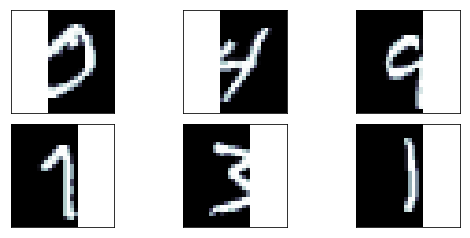

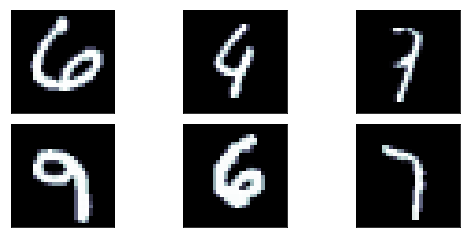

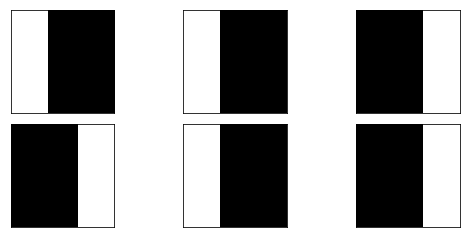

In [5]:
import matplotlib.pyplot as plt
import numpy as np

# Plot random train and test images

# Training images
fig, axes = plt.subplots(2, 3, figsize=(9, 4),
                         subplot_kw={'xticks':[], 'yticks':[]},
                         gridspec_kw=dict(hspace=0.1, wspace=0.1))
for i, ax in zip([1, 115, 460, 212, 130, 10020], axes.flat):
    ax.imshow(trainset.data[i], cmap='bone')
    
# Test images without patch 
fig, axes = plt.subplots(2, 3, figsize=(9, 4),
                         subplot_kw={'xticks':[], 'yticks':[]},
                         gridspec_kw=dict(hspace=0.1, wspace=0.1))
for i, ax in zip([201, 115, 1500, 212, 130, 122], axes.flat):
    ax.imshow(testset.data[i], cmap='bone')  

# Test images with only patch 
fig, axes = plt.subplots(2, 3, figsize=(9, 4),
                         subplot_kw={'xticks':[], 'yticks':[]},
                         gridspec_kw=dict(hspace=0.1, wspace=0.1))
for i, ax in zip([201, 115, 1500, 212, 130, 122], axes.flat):
    ax.imshow(testset1.data[i], cmap='bone')  
    
    
    

In [0]:
# Assign data to data loader

trainloader = torch.utils.data.DataLoader(trainset, batch_size = 64, shuffle = True, num_workers = 2)

testloader = torch.utils.data.DataLoader(testset, batch_size = 64, shuffle = False, num_workers = 2)

testloader1 = torch.utils.data.DataLoader(testset1, batch_size = 64, shuffle = False, num_workers = 2)

In [0]:
import torch.nn as nn
import torch.nn.functional as F

class linear_model(nn.Module):
  def __init__(self):
    super(linear_model, self).__init__()
    self.fc1 = nn.Linear(28*28, 1)
    self.fc2 = nn.Linear(28*28, 1)
    
  def forward(self, x):
    x = x.view(-1, 28*28)
    x1 = torch.sigmoid(self.fc1(x))
    x2 = torch.sigmoid(self.fc2(x))
    
    return x1, x2
  
model = linear_model()  

In [0]:
# Define loss function and optimizer
import torch.optim as optim

loss_function = nn.BCELoss(reduction = 'mean')

optimizer = optim.Adam(model.parameters(), lr = 0.001)

# def custom_loss(mat1, mat2):
#   # Absolute dot product of weights
#   #l = torch.abs(torch.mm(mat1, mat2.t()))
#   # Sum of squared difference between weights
#   #l = torch.sum((mat1 - mat2)*(mat1 - mat2))
#   # Log-absolute dot product of weights
#   l = torch.log(torch.abs(torch.mm(mat1, mat2.t())))
#   return l

class custom_loss(torch.nn.Module):

  def __init__(self):
    super(custom_loss,self).__init__()

  def forward(self, mat1, mat2):
  # Absolute dot product of weights
    l = torch.abs(torch.mm(mat1, mat2.t()))
  # Sum of squared difference between weights
#    l = torch.sum((mat1 - mat2)*(mat1 - mat2))
    return l

sl = custom_loss()    

In [37]:
n_epochs = 10
lmbda = 0.75

for epochs in range(n_epochs):
 
  running_loss = 0
  
  for batch in trainloader:
    data, targets = batch
    
    optimizer.zero_grad()
    
    output1, output2  = model(data)
    
    loss = loss_function(output1 , targets.float()) + loss_function(output2, targets.float())  + lmbda * sl.forward(model.fc1.weight, model.fc2.weight)
    
    loss.backward()
    
    optimizer.step()
    
#     print(model.fc1.weight)
#     print(model.fc2.weight)

    running_loss += loss.item()
  print(running_loss)    

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:512: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


1.499555246467935


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:512: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


1.4586977515937178
1.3070891713141464
1.5460873328629532
1.4083360830700258
1.3895689551936812
1.2406812926201383
1.5231380978657398
1.3492382352633285
1.3274478768216795


In [41]:
# Test performance on the entire test set
correct = 0
total = 0
with torch.no_grad():
  for data in testloader:
    images, labels = data
    outputs = model(images)
#    _, predicted = torch.max(outputs, 1)
    predicted = outputs[1] > 0.5
#   predicted = predicted.view(predicted.size(0))
    total += labels.size(0)
    matches = 0
    for i in range(len(predicted)):
      if predicted[i].item() == labels[i].item():
        matches += 1
    correct += matches#(predicted == labels).sum().item()
  print('Accuracy of the network on the entire data set is : %d %%' %(100 * correct/ total))

Accuracy of the network on the entire data set is : 50 %


In [0]:
# Compute the similarity between the weight vectors
sl(model.fc1.weight, model.fc2.weight)

tensor([[0.0208]], grad_fn=<AbsBackward>)